In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import networkx as nx
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from math import sqrt

### Read adata

In [2]:
root = "data/"
bif_batch1 = [("bifur1", tr, 1, 1, nc) for tr in [3, 5] for nc in [100, 150, 200, 250, 300]]

combined = bif_batch1
adata_list = []

for item in combined:
    bb, tr, sr, dg, nc = item
    path = root + "bif_batch1/bifurcating_" + str(tr) + "_1_1_" + str(nc)
    print(path)

    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))
    adata_list.append(adata)

data/bif_batch1/bifurcating_3_1_1_100
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_150
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_200
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_250
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_300
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_100
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_150
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_200
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_250
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_300
Transforming to str index.


In [3]:
len(adata_list)

10

### One Graph

In [10]:
dataset = RnaVeloDataset(root='data/')
i = 2
data = dataset[i]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

def train(data):
    model.train()
    optimizer.zero_grad()

    data = data.to(device)
    output = model(data)
    label = data.y.to(device)
    loss = F.mse_loss(output, label)
    loss.backward()
    optimizer.step()

    return float(loss)

def test(data):
    model.eval()
    
    correct = []
    predict = []
    data = data.to(device)
    label = data.y.detach().cpu().numpy().reshape(-1)
    pred = model(data).detach().cpu().numpy().reshape(-1)
    correct.extend(label)
    predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return mean_squared_error(correct, predict)

train_list = []
val_list = []

best_val_perf = test_perf = 0
for epoch in range(251):
    train_loss = train(data)
    train_acc = test(data)
    val_acc = test(data)
    test_acc = test(data)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc, test_acc))

    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.4407, Train: 0.4343, Val: 0.4343, Test: 0.4343
Epoch: 010, Loss: 0.3759, Train: 0.3691, Val: 0.3691, Test: 0.3691
Epoch: 020, Loss: 0.3033, Train: 0.2953, Val: 0.2953, Test: 0.2953
Epoch: 030, Loss: 0.2180, Train: 0.2093, Val: 0.2093, Test: 0.2093
Epoch: 040, Loss: 0.1308, Train: 0.1227, Val: 0.1227, Test: 0.1227
Epoch: 050, Loss: 0.0619, Train: 0.0569, Val: 0.0569, Test: 0.0569
Epoch: 060, Loss: 0.0283, Train: 0.0265, Val: 0.0265, Test: 0.0265
Epoch: 070, Loss: 0.0149, Train: 0.0139, Val: 0.0139, Test: 0.0139
Epoch: 080, Loss: 0.0080, Train: 0.0076, Val: 0.0076, Test: 0.0076
Epoch: 090, Loss: 0.0053, Train: 0.0052, Val: 0.0052, Test: 0.0052
Epoch: 100, Loss: 0.0039, Train: 0.0038, Val: 0.0038, Test: 0.0038
Epoch: 110, Loss: 0.0031, Train: 0.0030, Val: 0.0030, Test: 0.0030
Epoch: 120, Loss: 0.0026, Train: 0.0025, Val: 0.0025, Test: 0.0025
Epoch: 130, Loss: 0.0022, Train: 0.0022, Val: 0.0022, Test: 0.0022
Epoch: 140, Loss: 0.0020, Train: 0.0019, Val: 0.0019, Test: 0.

computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


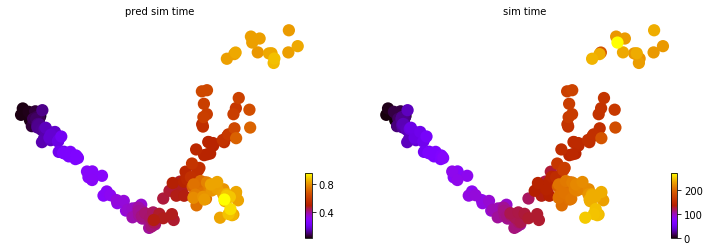

In [11]:
adata = adata_list[i]
scv.tl.velocity_graph(adata)
adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data', basis='pca')

### Batch

In [4]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

Processing...
data/bif_batch1/bifurcating_3_1_1_100
Transforming to str index.
computing neighbors
    finished(0:00:02)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Data(adata=AnnData object with n_obs × n_vars = 100 × 192 
    obs: 'cell_id', 'step_ix', 'simulation_i', 'sim_time', 'num_molecules', 'mult', 'lib_size', 'n_counts', 'velocity_self_transition'
    var: 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_settings', 

10

In [5]:
def train():
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        # print(pred.shape)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [6]:
dataset = RnaVeloDataset(root='data/')
batch_size = 2
train_loader = DataLoader(dataset[:8], batch_size=batch_size)
val_loader = DataLoader(dataset[8:10], batch_size=1)
# test_loader = DataLoader(dataset[40:45], batch_size=1)

data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.4936, Train: 0.4943, Val: 0.4307
Epoch: 010, Loss: 0.4730, Train: 0.4738, Val: 0.4103
Epoch: 020, Loss: 0.4521, Train: 0.4529, Val: 0.3892
Epoch: 030, Loss: 0.4293, Train: 0.4301, Val: 0.3662
Epoch: 040, Loss: 0.4032, Train: 0.4039, Val: 0.3401
Epoch: 050, Loss: 0.3720, Train: 0.3723, Val: 0.3092
Epoch: 060, Loss: 0.3332, Train: 0.3332, Val: 0.2712
Epoch: 070, Loss: 0.2874, Train: 0.2872, Val: 0.2272
Epoch: 080, Loss: 0.2370, Train: 0.2367, Val: 0.1811
Epoch: 090, Loss: 0.1872, Train: 0.1868, Val: 0.1412
Epoch: 100, Loss: 0.1500, Train: 0.1496, Val: 0.1216
Epoch: 110, Loss: 0.1307, Train: 0.1304, Val: 0.1177
Epoch: 120, Loss: 0.1204, Train: 0.1203, Val: 0.1141
Epoch: 130, Loss: 0.1142, Train: 0.1143, Val: 0.1108
Epoch: 140, Loss: 0.1104, Train: 0.1106, Val: 0.1087
Epoch: 150, Loss: 0.1080, Train: 0.1082, Val: 0.1070
Epoch: 160, Loss: 0.1064, Train: 0.1067, Val: 0.1058
Epoch: 170, Loss: 0.1053, Train: 0.1056, Val: 0.1048
Epoch: 180, Loss: 0.1045, Train: 0.1048, Val: 

Batch(adata=[1], batch=[250], edge_index=[2, 1554], x=[250, 10], y=[250, 1])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


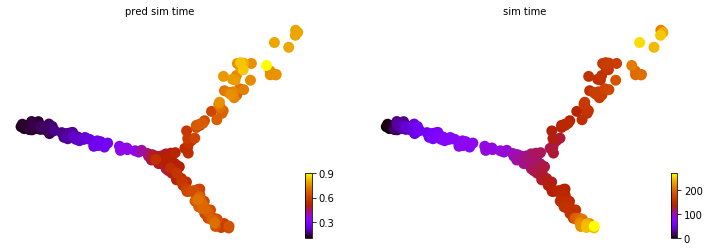

Batch(adata=[1], batch=[300], edge_index=[2, 1924], x=[300, 10], y=[300, 1])
computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


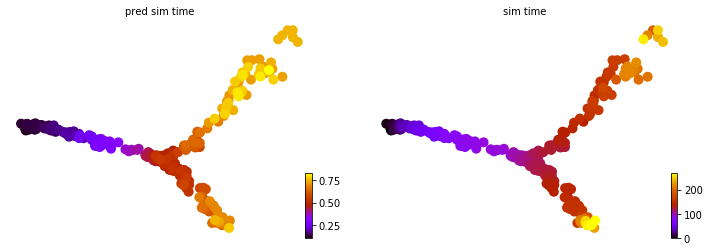

In [8]:
i = 8
model.eval()
for data in val_loader:
    print(data)
    adata = adata_list[i]
    scv.tl.velocity_graph(adata)
    adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    i += 1
    scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data')